# 0 - Install packages 

In [ ]:
!pip install the-teller

In [ ]:
!pip install BCN

# 1 - Import packages + data

In [39]:
import BCN as bcn # takes a long time to run, ONLY the first time it's run
import teller as tr
import numpy as np
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn import metrics
from time import time

**import `diabetes` dataset**

In [40]:
# https://scikit-learn.org/stable/datasets/toy_dataset.html#diabetes-dataset

dataset = load_diabetes()
X = dataset.data
y = dataset.target

# split data into training test and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, random_state=13)

In [41]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(353, 10)
(353,)
(89, 10)
(89,)


In [42]:
print(y.mean())

152.13348416289594


In [43]:
print(y.std())

77.00574586945044


# 2 - Adjust BCN model to training set, eval on test set

In [44]:
start = time()

regr_bcn = bcn.BCNRegressor(**{'B': 122,
 'nu': 0.7862040612242153,
 'col_sample': 0.6797268557618982,
 'lam': 0.9244772287770061,
 'r': 0.18915458607547728,
 'tol': 9.670499926559012e-10})

regr_bcn.fit(X_train, y_train)

print(f"\nElapsed {time() - start}") 

preds = regr_bcn.predict(X_test)

print(np.sqrt(np.mean(np.square(y_test - preds))))

  |======================================================================| 100%

Elapsed 0.641953706741333
54.50979209778048


# 3 - Adjust the teller's Explainer to test set

In [45]:
start = time()

# creating an Explainer for the fitted object `regr_bcn`
expr = tr.Explainer(obj=regr_bcn)

# confidence int. and tests on covariates' effects (Jackknife)
expr.fit(X_test, y_test, X_names=dataset.feature_names, method="ci")

# summary of results
expr.summary()

# timing
print(f"\n Elapsed: {time()-start}")



Score (rmse): 
 54.51


Residuals: 
       Min         1Q   Median        3Q        Max
-119.79528 -30.293474 9.749065 45.169791 124.891462


Tests on marginal effects (Jackknife): 
       Estimate Std. Error  95% lbound  95% ubound  Pr(>|t|)     
bmi  534.170652  10.538064  513.228463   555.11284       0.0  ***
s5   460.090298    11.7154  436.808403  483.372194       0.0  ***
bp   245.510926   7.073121  231.454584  259.567267       0.0  ***
s6   117.899033   8.865569  100.280578  135.517488       0.0  ***
s4     71.20425   4.885591   61.495165   80.913336       0.0  ***
age    3.144209   7.616405  -11.991795   18.280213  0.680742    -
s1    -31.76086   8.823018  -49.294754  -14.226967  0.000526  ***
s2  -104.139443   8.596589 -121.223357  -87.055529       0.0  ***
sex -167.461194    3.92965 -175.270546 -159.651841       0.0  ***
s3  -210.749954   5.580957 -221.840934 -199.658975       0.0  ***


Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘-’ 1


Multiple R-squared:  0.

# 4 - Prediction intervals

## 4 - 1 Split conformal

In [46]:
pi = tr.PredictionInterval(regr_bcn, method="splitconformal", level=0.95)

In [47]:
pi.fit(X_train, y_train)

  |======================================================================| 100%


PredictionInterval(obj=BCNRegressor(B=122, col_sample=0.6797268557618982,
                                    lam=0.9244772287770061,
                                    nu=0.7862040612242153,
                                    r=0.18915458607547728,
                                    tol=9.670499926559012e-10))

In [48]:
preds = pi.predict(X_test, return_pi=True)

In [49]:
pred = preds[0]
y_lower = preds[1]
y_upper = preds[2]
print(len(pred))

# average coverage
print(np.mean((y_test >= y_lower) & (y_test <= y_upper)))
length_pi = y_upper - y_lower
print(np.mean(length_pi))

89
0.9438202247191011
209.55455918396666


## 4 - 2 Local conformal

In [50]:
pi2 = tr.PredictionInterval(regr_bcn, method="localconformal", level=0.95)

In [51]:
pi2.fit(X_train, y_train)

  |======================================================================| 100%


PredictionInterval(method='localconformal',
                   obj=BCNRegressor(B=122, col_sample=0.6797268557618982,
                                    lam=0.9244772287770061,
                                    nu=0.7862040612242153,
                                    r=0.18915458607547728,
                                    tol=9.670499926559012e-10))

In [52]:
preds2 = pi2.predict(X_test, return_pi=True)

In [53]:
pred2 = preds2[0]
y_lower2 = preds2[1]
y_upper2 = preds2[2]
print(len(pred2))

# compute and display the average coverage
print(np.mean((y_test >= y_lower2) & (y_test <= y_upper2)))
length_pi2 = y_upper2 - y_lower2
print(np.mean(length_pi2))

89
0.9550561797752809
229.03014949955275


# 5 - Plot prediction intervals

In [54]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt

import numpy as np
np.warnings.filterwarnings('ignore')


split_color = 'tomato'
local_color = 'gray'

%matplotlib inline
np.random.seed(1)


def plot_func(x,
              y,
              y_u=None,
              y_l=None,
              pred=None,
              shade_color="",
              method_name="",
              title=""):
        
    fig = plt.figure()
    
    plt.plot(x, y, 'k.', alpha=.3, markersize=10,
             fillstyle='full', label=u'Test set observations')
    
    if (y_u is not None) and (y_l is not None):
        plt.fill(np.concatenate([x, x[::-1]]),
                 np.concatenate([y_u, y_l[::-1]]),
                 alpha=.3, fc=shade_color, ec='None',
                 label = method_name + ' Prediction interval')
    
    if pred is not None:        
        plt.plot(x, pred, 'k--', lw=2, alpha=0.9,
                 label=u'Predicted value')
    
    #plt.ylim([-2.5, 7])
    plt.xlabel('$X$')
    plt.ylabel('$Y$')
    plt.legend(loc='upper right')
    plt.title(title)
    
    plt.show()

**Split conformal**

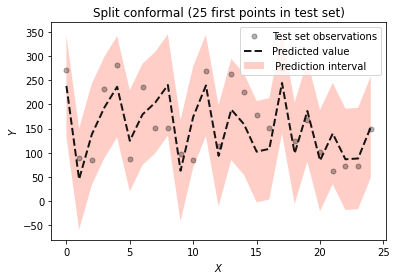

In [55]:
max_idx = 25
plot_func(x = range(max_idx),
          y = y_test[0:max_idx],
          y_u = y_upper[0:max_idx],
          y_l = y_lower[0:max_idx],
          pred = pred[0:max_idx],
          shade_color=split_color, 
          title = f"Split conformal ({max_idx} first points in test set)")


**Local conformal**

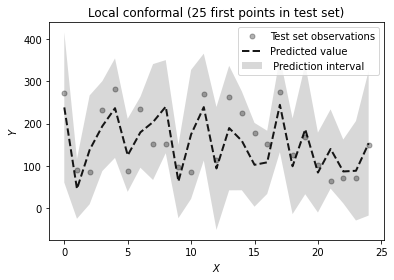

In [56]:
max_idx = 25
plot_func(x = range(max_idx),
          y = y_test[0:max_idx],
          y_u = y_upper2[0:max_idx],
          y_l = y_lower2[0:max_idx],
          pred = pred2[0:max_idx],
          shade_color=local_color, 
          title = f"Local conformal ({max_idx} first points in test set)")